In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError

# SEA dataset

Example of how to use the concept drift detection method DDM {cite:p}`gama2004learning` with a data stream blocks (concepts) from the SEA {cite:p}`street2001streaming` generator.

According to the artificial data generated in SEA {cite:p}`street2001streaming`, a concept or block is defined as follows:

$$
class(x) = \left\{
  \begin{array}{ll}
    1 & \text{if } x_1 + x_2 \leq \theta \\
    0 & \text{otherwise}
  \end{array}
\right.
$$

where $x_1$ and $x_2$ are two features (SEA {cite:p}`street2001streaming` includes another feature $x_{3}$, that is irrelevant), and $\theta$ is a threshold that differentiates the two classes. Four different concepts/blocks are defined depending on the value of $\theta$. Concept 1: $\theta = 8$; Concept 2: $\theta = 9$; Concept 3: $\theta = 7$; Concept 4: $\theta = 9.5$.

In this case Concepts 1 and 3 are used without any added noise. The first one is used to train a model, warm-up the detector and also for the testing phase. While the other is only used for induce concept drift in the testing phase. Therefore, the two different concepts can be represented in two different phases. The warm-up phase where $\theta_{warm-up}(t) = 8$ (Concept 1) and the testing phase where Concept 1 is used at the beginning to show that the detector is not triggered by the same concept and Concept 3 is used later to trigger a drift signal: 

$$
\theta_{test}(t) = \left\{
  \begin{array}{ll}
    8 & \text{if } 0 \leq t < 10000 \\
    7 & \text{if } 10000 \leq t < 20000 \\
  \end{array}
\right.
$$

The data both for the training and warm-up phase is generated by using the SEA generator with Concept 1. The number of samples is set to 20000, so 10000 samples are used for training and 10000 for warming-up the detector.

In [2]:
random_state = 31

concept_samples = 20000
generator = SEA(seed=random_state)
noise = 0.0

reference_concept = generator.generate_dataset(
    block=1,  # Concept 1
    noise=noise,
    num_samples=concept_samples,
)

X_reference, y_reference = [], []
for sample, label in reference_concept:
    X_reference.append(sample)
    y_reference.append(label)
X_reference, y_reference = np.array(X_reference), np.array(y_reference).reshape(-1, 1)

## Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

split_idx = concept_samples // 2  # 10000 each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

The test dataset is generated by using the SEA generator with Concept 1 and Concept 3. The first one is expected to not trigger any drift, while the second one should trigger a drift signal.

In [3]:
test_concepts = [generator.generate_dataset(
    block=block,
    noise=noise,
    num_samples=10000,
) for block in [1, 3]]  # Concepts 1 and 3

X_test, y_test = [], []
for concept in test_concepts:
    for sample, label in concept:
        X_test.append(sample)
        y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

A configuration class with the detector parameters is defined. In this particular case, it only contains the warning and drift threshold levels, along with the minimum number of instances to start checking for drift. In this case, the minimum number of instances is set to the number of samples in the warmup dataset, meaning that the detector will start checking for drift from the first sample of the test dataset and it will trigger a drift signal if the expected error is significantly higher than the error obtained in the warmup dataset.

In [4]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(X_warmup),  # 500
)

The detector can be defined by passing the previously defined configuration class.

In [5]:
detector = DDM(
    config=config,
)

We fit a simple decision tree classifier with the default parameters to the training dataset.

In [6]:
model = DecisionTreeClassifier(
    random_state=random_state,
)
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(random_state=31)

Some metrics are used during the stream simulation can be tracked. In this case, we set prequential error with $\alpha = 1.0$, $\alpha = 0.9999$ and $\alpha = 0.999$. When  is $\alpha = 1.0$ can be seen as an accuracy metric that weights each sample error with the same weight, while the other ones give 99.99% and 99.9% weight respectively to the previous samples and the remaining 0.01% and 0.1% weight to the new error value.

In [7]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

We define a simple error scorer function that returns 0 (no error) if the prediction is correct and 1 otherwise (error).

In [8]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

The warm-up phase can be seen as a fitting phase, in which the detector receives the warm-up samples in a sequential order and updates its internal state. In this case, samples from X_warmup are used to warm-up the detector.

In [9]:
# Warm-up detector
print(f"Warming-up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X=X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

Warming-up detector with 10000 samples


To demonstrate the use of the detector, a data stream is simulated by iterating over the test dataset. In this example, it is assumed that all ground-truth values are available in sequential order. However, it's worth noting that the update method of the detector object could be called on demand and not strictly sequentially, assuming you have all the labels.

In [10]:
idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

Drift detected at index: 20299


Finally, the performance of the model over time and interactions with the detector are plotted.

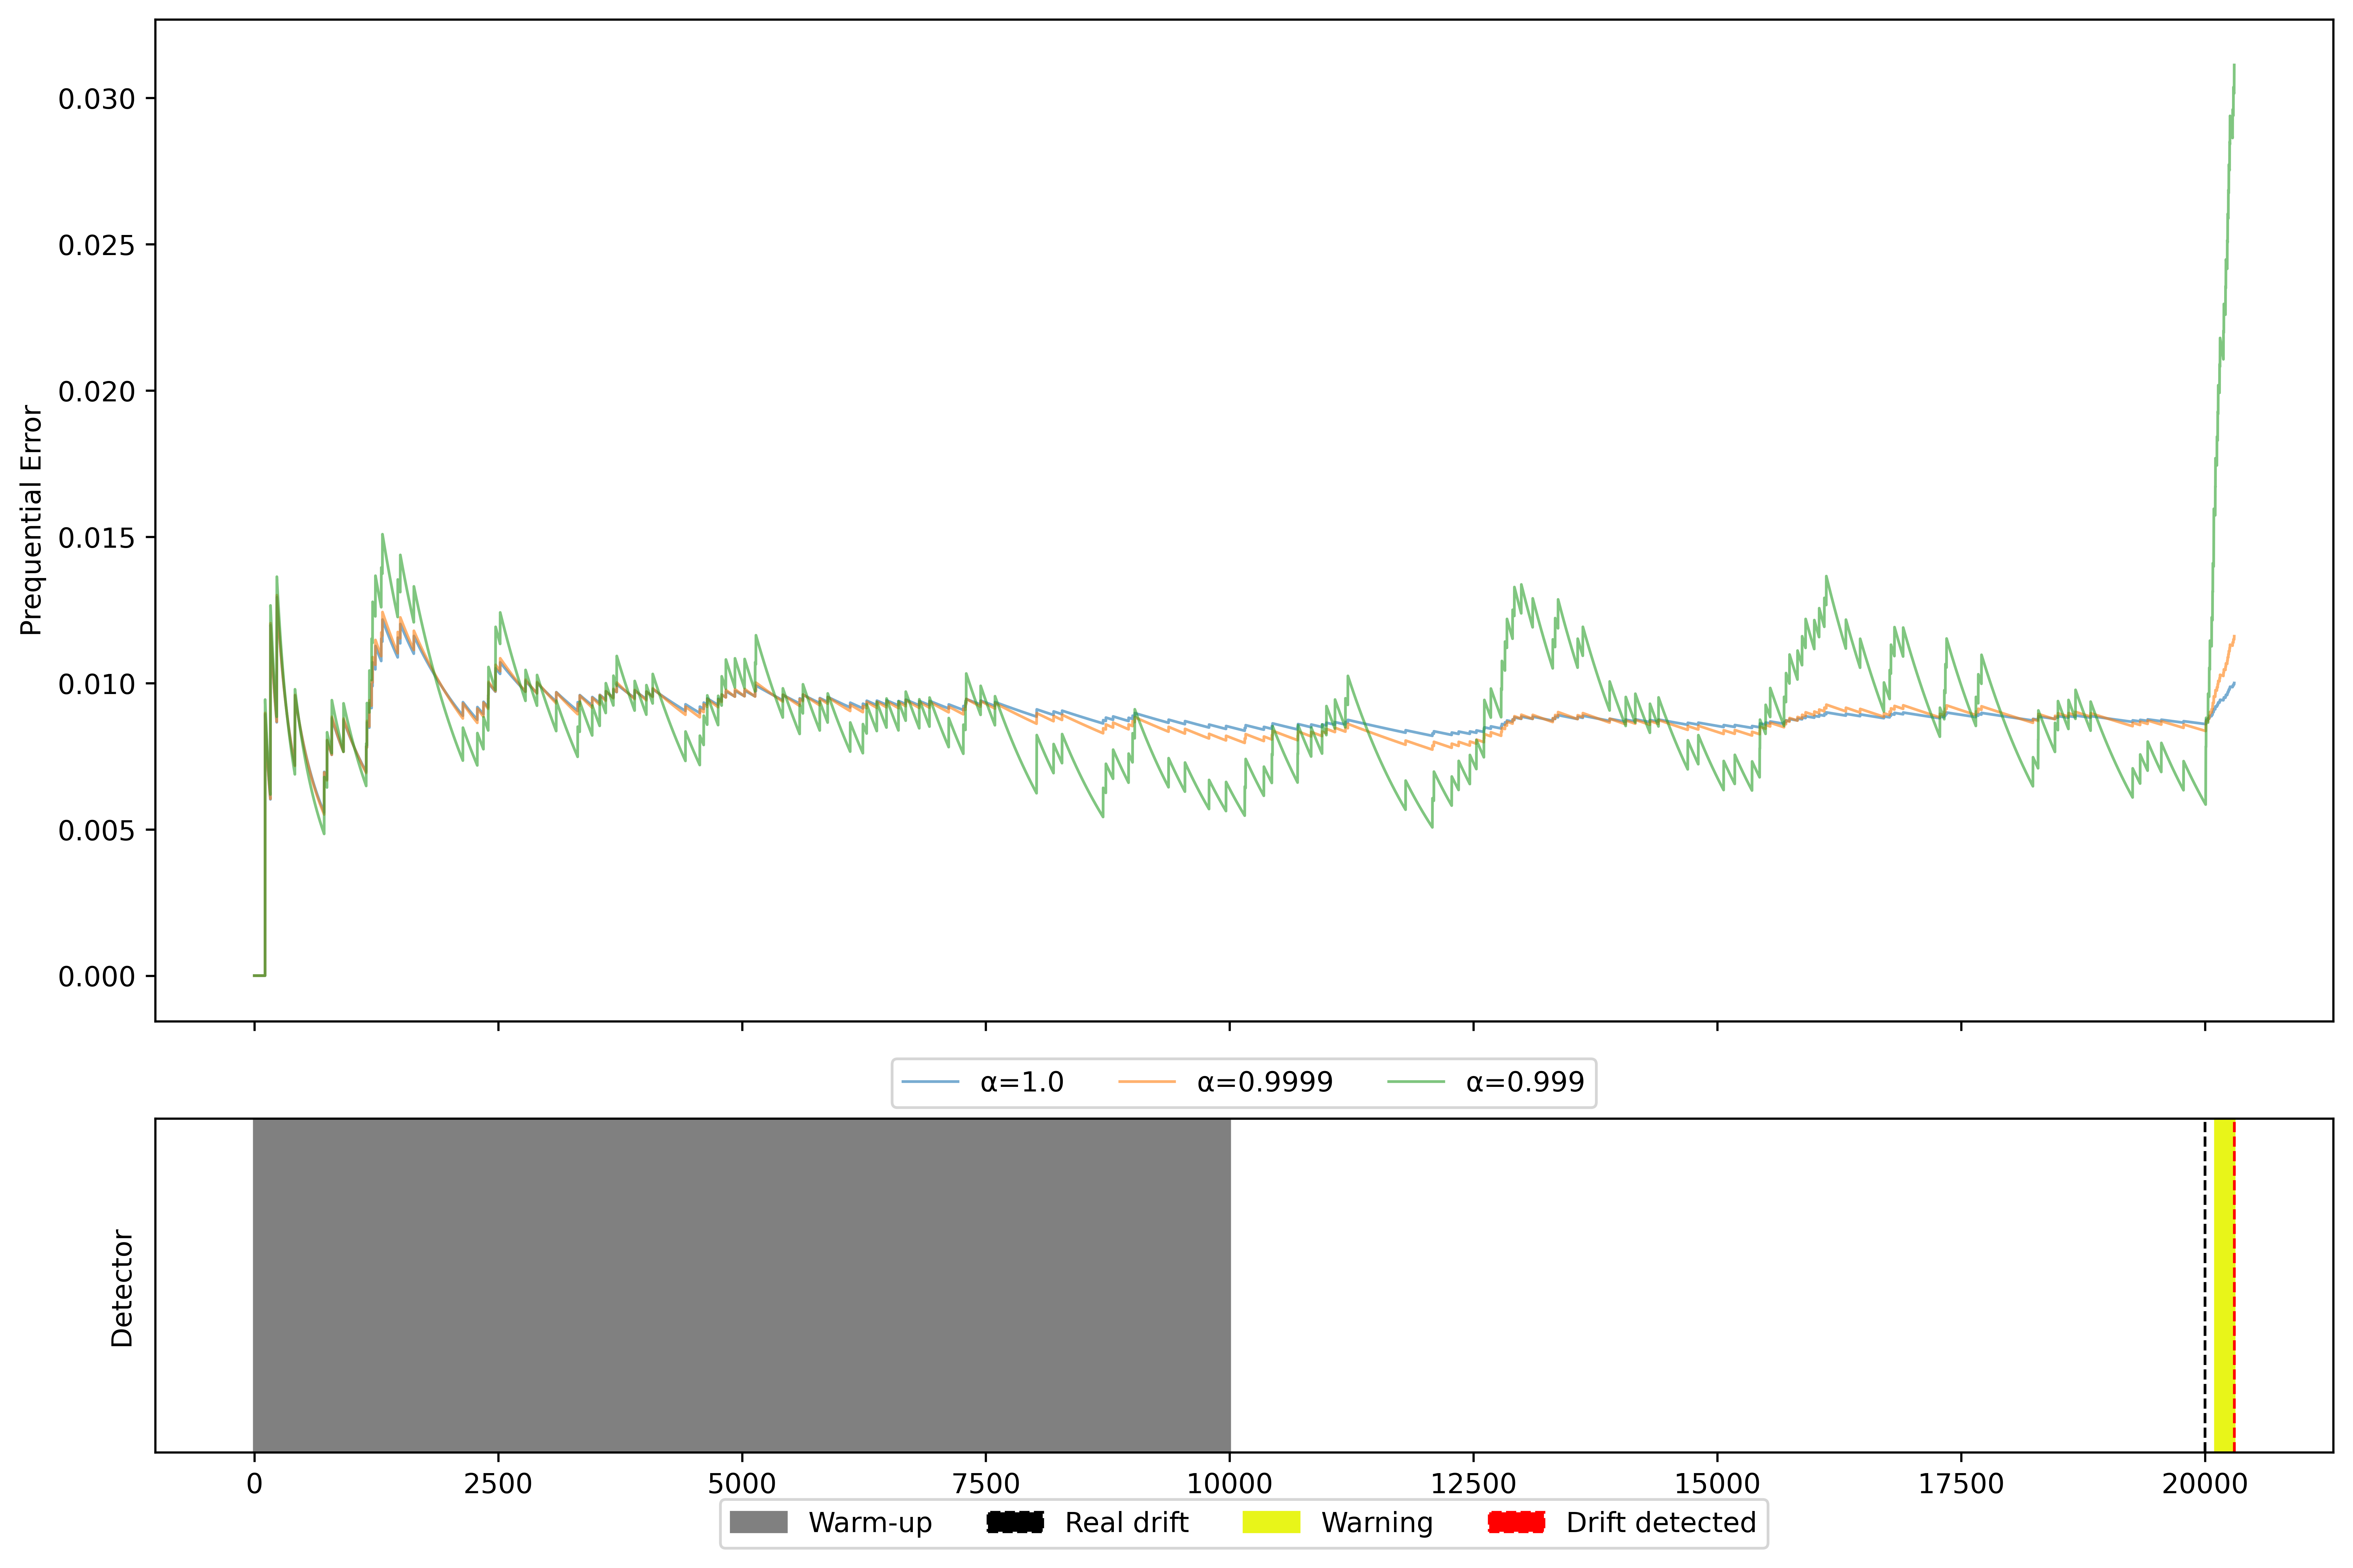

In [11]:
alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=600,
    gridspec_kw={'height_ratios': [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
        metrics_historic_detector.items(),
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(metric_values,
               color=linecolor,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx,
                  color=warmup_color,
                  linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=linewidth)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.1),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift detected", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm-up")
real_drift_path = mpatches.Patch(color=real_drift_color, label="Real drift", linestyle=drift_linestyle)
ax[1].axvline(x=20000,
              color=real_drift_color,
              linestyle=drift_linestyle,
              linewidth=linewidth)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.1),
    fancybox=True,
)

fig.tight_layout()
plt.show()

Taking into account that the detector has been previously warmed up on Concept/Block 1 of SEA {cite:p}`street2001streaming` generator, the results can be interpreted as follows:
1. [0 - 9999] (Concept 1): 
- The detector is warmed up with 10000 samples from Concept 1, the error stays stable around less than 1% (looking at the $\alpha=1.0$ and $\alpha=0.9999$ metrics). In this phase, the detector is not able to detect drift yet, since the minimum number of instances to start checking for drift is set to 10000 (the number of samples in the warmup dataset).
2. [10000 - 19999] (Concept 1):
- The detector is ready to start checking for drift. In this case, we use samples also from Concept 1, so the error remains stable and the detector does not detect drift, which is the expected behavior.
3. [20000 - 20299] (Concept 3):
- From now on, the detector is receiving samples from Concept 3, so the error starts to increase significantly, as it can be seen in $\alpha=0.999$. The detector enters a warning zone and a few samples later, drift is detected at index 20299.
- Since we are not using any callback, it would be up to the user to decide what to do next, whether to leave the model running, knowing that a concept change has occurred, or to retrain it. 

```{bibliography}
:filter: docname in docnames
```